In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define transforms for training and testing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))
])

# Load CIFAR-100 dataset (built-in)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = trainset.classes
print("Total classes:", len(classes))

Total classes: 100


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 100)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {running_loss/len(trainloader):.3f}  Accuracy: {acc:.2f}%")

print("Training complete ✅")

Epoch [1/20]  Loss: 4.079  Accuracy: 6.79%
Epoch [2/20]  Loss: 3.641  Accuracy: 12.62%
Epoch [3/20]  Loss: 3.426  Accuracy: 16.02%
Epoch [4/20]  Loss: 3.271  Accuracy: 18.83%
Epoch [5/20]  Loss: 3.143  Accuracy: 21.05%
Epoch [6/20]  Loss: 3.044  Accuracy: 22.88%
Epoch [7/20]  Loss: 2.955  Accuracy: 24.51%
Epoch [8/20]  Loss: 2.886  Accuracy: 25.79%
Epoch [9/20]  Loss: 2.820  Accuracy: 27.09%
Epoch [10/20]  Loss: 2.754  Accuracy: 28.27%
Epoch [11/20]  Loss: 2.702  Accuracy: 29.72%
Epoch [12/20]  Loss: 2.656  Accuracy: 30.28%
Epoch [13/20]  Loss: 2.603  Accuracy: 31.25%
Epoch [14/20]  Loss: 2.558  Accuracy: 32.15%
Epoch [15/20]  Loss: 2.517  Accuracy: 33.22%
Epoch [16/20]  Loss: 2.474  Accuracy: 34.02%
Epoch [17/20]  Loss: 2.439  Accuracy: 34.92%
Epoch [18/20]  Loss: 2.405  Accuracy: 35.65%
Epoch [19/20]  Loss: 2.368  Accuracy: 36.44%
Epoch [20/20]  Loss: 2.339  Accuracy: 37.09%
Training complete ✅


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 48.48%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41047615..1.512129].


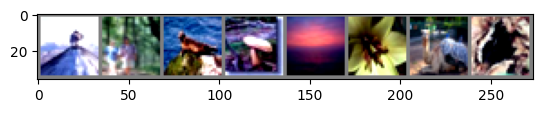

Predicted: ['bridge', 'forest', 'otter', 'mushroom', 'sea', 'spider', 'kangaroo', 'shrew']
Actual:    ['mountain', 'forest', 'seal', 'mushroom', 'sea', 'tulip', 'camel', 'butterfly']


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Move to device and predict
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('Predicted:', [classes[p] for p in predicted[:8]])
print('Actual:   ', [classes[l] for l in labels[:8]])